In [1]:
import tensorflow as tf
# config = tf.ConfigProto() 
# config.gpu_options.allow_growth = True 
# session = tf.Session(config=config) 

/home/visal/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/visal/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/visal/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/visal/anaconda3/envs/keras/lib/python3.7/site-

In [2]:
import random as rn 
import numpy as np
import os 
os.environ['PYTHONHASHSEED'] = '0' 
np.random.seed(70) 
rn.seed(70) 
tf.set_random_seed(70) 

In [5]:
import pandas as pd

In [6]:
data = pd.read_excel('../../../data prep/address_iob_v5/address_iob_v5.xlsx', keep_default_na=False)

In [7]:
data['word'] = data['word'].str.replace('\u200b', '', regex=True)
data['tag'] = data['tag'].str.replace('\u200b', '', regex=True)

In [8]:
import plotly.express as px

fig = px.histogram(data[~data.tag.str.contains("O")], x="tag",color="tag")
fig.show()

In [9]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].str.lower().values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
largest_sen = max(len(sen) for sen in sentences)
maxlen = largest_sen
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 28 words


In [11]:
words = set(list(data['word'].str.lower().values))
#words = set(list(data['word'].values))
words.add('PADword')
n_words = len(words)

tags = []
# for tag in set(data["tag"].values):
#     if tag is nan or isinstance(tag, float):
#         tags.append('unk')
#     else:
#         tags.append(tag)


tags = list(set(data["tag"] )
n_tags = len(tags)

In [12]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}
idx2word = {v: k for k, v in iteritems(word2idx)}

In [13]:
data['Word_idx'] = data['word'].str.lower().map(word2idx)
data['Tag_idx'] = data['tag'].map(tag2idx) 

In [14]:
data['word'] = data['word'].str.lower()

In [15]:
# Groupby and collect columns
data_group = data.groupby(
['sentence_idx'],as_index=False
)['word', 'tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/home/visal/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [16]:
len(data_group)

16476

In [17]:
data_group['liststring'] = [','.join(map(str, l)) for l in data_group['Word_idx']]

In [18]:
data_group.drop_duplicates(subset='liststring', keep='first', inplace=True)

In [19]:
data_group.drop(['liststring'], axis=1, inplace=True)

In [20]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['word'].to_list())))
    n_tag = len(list(set(data['tag'].to_list())))

    # Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= word2idx['PADword'])

    # tokens = []
    # X = [[w[0]for w in s] for s in sentences]
    # for seq in X:
    #     new_seq = []
    #     for i in range(maxlen):
    #         try:
    #             new_seq.append(seq[i])
    #         except:
    #             new_seq.append("PADword")
    #     tokens.append(new_seq)  
        
    # pad_tokens = []
    # for token_i in tokens:
    #     out_i = []
    #     for t in token_i:
    #         out_i.append(word2idx[t])
    #     pad_tokens.append(out_i)
        
    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)


train_tokens length: 11103 
test_tokens length: 1645 
test_tags: 1645 
val_tokens: 3702 
val_tags: 3702


Using TensorFlow backend.


In [21]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
maxlen = max([len(s) for s in sentences])

input = Input(shape=(maxlen,))
word_embedding_size = 6

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size,
input_length=maxlen)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5))(model)
                           
# model = LSTM(units=word_embedding_size * 2, 
#              return_sequences=True, 
#              dropout=0.5, 
#              recurrent_dropout=0.5, 
#              kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
from keras.callbacks import EarlyStopping 
early_stopping_monitor = EarlyStopping(
    monitor='val_crf_viterbi_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

In [23]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


#Optimiser 
#adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
adam = k.optimizers.Adam(lr=0.02)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/home/visal/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning:

CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.

/home/visal/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning:

CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 28, 6)             27534     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 12)            624       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 9)             117       
_________________________________________________________________
crf_1 (CRF)                  (None, 28, 9)             189       
Total params: 28,464
Trainable params: 28,464
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fit the best model
history = model.fit(x=np.array(train_tokens), y=np.array(train_tags),
    batch_size=32, verbose=1, epochs=50, 
    validation_data=(np.array(val_tokens), np.array(val_tags)),
    callbacks=[early_stopping_monitor])

Instructions for updating:
Use tf.cast instead.
Train on 11103 samples, validate on 3702 samples
Epoch 1/50


2022-08-24 15:25:23.401982: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-08-24 15:25:23.423880: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2022-08-24 15:25:23.424555: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x559fa0e57fc0 executing computations on platform Host. Devices:
2022-08-24 15:25:23.424585: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-08-24 15:25:25.135011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 15:25:25.135236: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x559f9eb10dd0 executing computations on platform CUDA. Devices:
2022-08-24 15:25:25.135255: I tensorflow/compiler

   32/11103 [..............................] - ETA: 20:03 - loss: 2.5670 - crf_viterbi_accuracy: 0.1797

2022-08-24 15:25:26.707252: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


11103/11103 [==============================] - 22s 2ms/step - loss: 0.0489 - crf_viterbi_accuracy: 0.9384 - val_loss: -0.2457 - val_crf_viterbi_accuracy: 0.9949
Epoch 2/50
11103/11103 [==============================] - 18s 2ms/step - loss: -0.3646 - crf_viterbi_accuracy: 0.9933 - val_loss: -0.4942 - val_crf_viterbi_accuracy: 0.9953
Epoch 3/50
11103/11103 [==============================] - 18s 2ms/step - loss: -0.6170 - crf_viterbi_accuracy: 0.9946 - val_loss: -0.7456 - val_crf_viterbi_accuracy: 0.9964
Epoch 4/50
11103/11103 [==============================] - 19s 2ms/step - loss: -0.8672 - crf_viterbi_accuracy: 0.9951 - val_loss: -0.9951 - val_crf_viterbi_accuracy: 0.9971
Epoch 5/50
11103/11103 [==============================] - 19s 2ms/step - loss: -1.1153 - crf_viterbi_accuracy: 0.9950 - val_loss: -1.2432 - val_crf_viterbi_accuracy: 0.9970
Epoch 6/50
11103/11103 [==============================] - 19s 2ms/step - loss: -1.3623 - crf_viterbi_accuracy: 0.9948 - val_loss: -1.4877 - val_crf

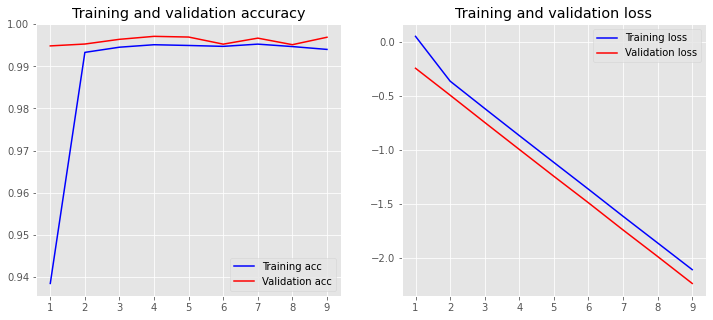

In [25]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['crf_viterbi_accuracy']
    val_accuracy = history.history['val_crf_viterbi_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [26]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(np.array(test_tokens), verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(test_tags)

1645/1645 [==============================] - 1s 746us/step


In [27]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels[:600], pred_labels[:600])))

F1-score: 99.4%


In [28]:
tags

['B-village_phum',
 'I-village_phum',
 'B-district_srok',
 'I-city_province',
 'I-district_srok',
 'O',
 'B-commune_khum',
 'I-commune_khum',
 'B-city_province']

In [29]:
print(classification_report(test_labels[:600], pred_labels[:600]))

               precision    recall  f1-score   support

city_province       0.99      1.00      1.00       593
 commune_khum       0.99      0.99      0.99       586
district_srok       0.99      1.00      1.00       589
 village_phum       0.98      0.99      0.99       560

    micro avg       0.99      1.00      0.99      2328
    macro avg       0.99      1.00      0.99      2328
 weighted avg       0.99      1.00      0.99      2328



In [30]:
print("Evaluate on test data")
results = model.evaluate(np.array(val_tokens), np.array(val_tags))
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
3702/3702 [==============================] - 2s 638us/step
test loss: -0.9950929851161023 
test accuracy: 0.9971347491461673 


In [31]:
data

,sentence_idx,word,tag,Word_idx,Tag_idx
0,1,pa,B-village_phum,168,0
1,1,chon,I-village_phum,1575,1
2,1,thum,I-village_phum,2772,1
3,1,",",O,2904,5
4,1,aekakpheap,B-commune_khum,1738,6
...,...,...,...,...,...
169787,16474,riverside,O,7,5
169788,16475,olympia,O,1944,5
169789,16475,city,O,581,5
169790,16476,one,O,4338,5


In [32]:
from matplotlib.pyplot import axis

# words = list(set(data["word"].values))
# tags = list(set(data["tag"].values))

i = np.random.randint(0, len(val_tokens))
print("This is sentence:",i)
p1 = model.predict(np.array(val_tokens))[i]
p = np.argmax(p1, axis=-1)
v_tags = np.argmax(val_tags[i], axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(val_tokens[i], val_tags[i], p):
    true=np.argmax(true, axis=-1)
    if idx2word[w] != 'PADword':
        print("{:15}{:15}\t{:15}".format(idx2word[w], tags[true], tags[pred]))

This is sentence: 1661
Word           True 	 Pred

------------------------------
bet            B-commune_khum 	B-commune_khum 
trang          I-commune_khum 	I-commune_khum 
,              O              	O              
prey           B-district_srok	B-district_srok
nob            I-district_srok	I-district_srok
,              O              	O              
sihanouk       B-city_province	B-city_province


## saved model

In [41]:
# import json 
# def dict_to_json(dic, path):
#     with open(path, "w") as outfile:
#         json.dump(dic, outfile)
# dict_to_json(word2idx,"./vocab/word2idx.json")        
# dict_to_json(tag2idx,"./vocab/tag2idx.json")  
# dict_to_json(idx2tag,"./vocab/idx2tag.json")  
# dict_to_json(idx2word,"./vocab/idx2word.json")  

In [42]:
# model.save('./model.h5')

: 

## load model

In [35]:
# from keras_contrib.losses import  crf_loss
# from keras_contrib.metrics import crf_viterbi_accuracy
# from keras.models import load_model

In [36]:
# custom_objects = {'CRF': CRF, 'crf_loss':crf_loss, 'crf_viterbi_accuracy':crf_viterbi_accuracy}

In [37]:
# lol = load_model('./model/test_model.h5', custom_objects)

In [38]:
# def pred2label(pred):
#     out = []
#     for pred_i in pred:
#         out_i = []
#         for p in pred_i:
#             p_i = np.argmax(p)
#             out_i.append(idx2tag[p_i])
#         out.append(out_i)
#     return out
# test_pred = lol.predict(test_tokens, verbose=1)   
# pred_labels = pred2label(test_pred)
# test_labels = pred2label(test_tags)

In [39]:
# print("Evaluate on test data")
# results = lol.evaluate(val_tokens, np.array(val_tags), batch_size=128)
# print("test loss: {} ".format(results[0]))
# print("test accuracy: {} ".format(results[1]))

In [40]:
# from matplotlib.pyplot import axis

# # words = list(set(data["word"].values))
# # tags = list(set(data["tag"].values))

# i = np.random.randint(0, val_tokens.shape[0])
# print("This is sentence:",i)
# p1 = lol.predict(np.array([val_tokens[i]]))
# p = np.argmax(p1, axis=-1)
# v_tags = np.argmax(val_tags[i], axis=-1)

# print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
# print("-" *30)
# for w, true, pred in zip(np.array(val_tokens[i]), val_tags[i], p[0]):
#     true=np.argmax(true, axis=-1)
#     print("{:15}{:15}\t{:15}".format(words[w], tags[true], tags[pred]))
#     #print(np.argmax(true, axis=-1))